<center>
    <span style="color:blue; font-family:Georgia;  font-size:2em;">
        <h1>Clustering data - Crisp Algorithms</h1></span>
 </center>
        <p> </p>
        <p> </p>
        <center><span style="color:blue; font-family:Georgia;  font-size:1em;">
        Ramon Béjar Torres</span></center>
        <canvas id="myCanvas" width="200" height="100" style="border:0px solid"></canvas>
        <center>Data mining - Master on Computer Science</center>
        <center><img src="M-UdL2.png"  width="200" alt="UdL Logo"></center>


We are going to discuss in this notebook an approach to the problem of clustering data sets. We consider data sets of points, where each point is considered to be a $d-$ dimensional numeric vector in an euclidean space.

Given a data set, a cluster is a subset of points of the data set that are somehow related to each other.

That is, they share some similar features, or we say that globally they form a group of related/similar points. 

For example, consider different demografic and economic variables for the countries. Do we observe a clear division between countries when  looking at those indicators ?

That we assume an euclidean space is at least necessary for the two algorithms we present here, k-means and Bisecting k-means, as they consider euclidean distances between points when measuring how close is each point to its cluster center, and the variance within each cluster produced. 

The algorithms we consider here are examples of **unsupervised learning** algorithms:
- They learn to what cluster belongs each data point without the prior knowledge of any *good* examples of points already well linked to their clusters.
- So, the algorithms work without practical clues about what points contain each cluster. In other words, they **discover** concepts without prior human assistance about how are the concepts they should find.

In [ ]:
#
# Our preliminary set-up code
#

import pyspark
import os
import math
import random
import sys

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


spark_home = os.environ.get('SPARK_HOME', None)
sc = pyspark.SparkContext('local[*]')

print (spark_home, sc)

## Exact (crisp) clustering with Lloyd algorithm (k-Means)

We first consider the problem of **exact** clustering. We assume that there exist k clusters (groups of points), and that each point in our data set belongs to **exactly one** of the k clusters. We start assuming that we know the right number of clusters $k$, although this value is usually something we have to guess in real applications of clustering.

For presenting the algorithm, we need to introduce some definitions:

- Target set of data points: Target set of $n$-dimensional points $D=\{X_1,X_2,\ldots,X_m \}$

- Euclidean distance between two points: $ || x-y || = \sqrt{ \sum_{i = 1}^{n} (x_i-y_i)^2 } $  

- Centroid or center of a subset Y:  $  \frac{1}{|Y|} \sum_{y \in Y} y $ 

- Within-cluster sum of square errors (WCSSE) for a set of clusters C: 
$$ \sum_{c \in C} \sum_{x \in c} || x-center(c) ||^2 $$

Then, Lloyd algorithm considers that a cluster:
- Is defined simply by its center
- The set of points that belong to a cluster is the set of points with smaller euclidean distance to that center than to any other cluster center.

We can think about the cluster center as being the mean representative point of the cluster 
> Observe that it can be the case that there is no single point in our data set that is exactly equal to that cluster center.


Then, Lloyd algorithm finds a set of k clusters with the following iterative WCSSE improving algorithm:

```python
clusters = Initial Guess for k clusters centers  
iters = 1  
while (clusters changed significantly  &   iters <= limit) do:  
  # Assign closest cluster to each point
  for p in D:
      clusterFor(p) = NearestClusterCenter(clusters,p)     
  # Find best new set of cluster centers   
  for c in [1,2,...,k]: 
      clusters(c) = centroid(points in D assigned to c)  
  iters = iters + 1 
```

From the two conditions to stop modifying the clusters:
- the first one refers to measuring the difference of the clusters between the previous iterations and the current one. We need to define what we mean by *changed significantly*, but usually that means that the distance between at least one pair (old_center_i,new_center_i), for some cluster i, is greater than certain threshold value. 
- the second one is about reaching some maximum number of iterations. This is always necessary, as k-means may need sometimes a big number of iterations to reach the desired optimal clusters. Actually, it has been proven that there are cases where it needs an exponential number of iterations:
> "k-means Requires Exponentially Many Iterations Even
in the Plane" https://cseweb.ucsd.edu/~avattani/papers/kmeans.pdf


In the Spark implementation of k-means, we can specify these two stopping conditions.

### Parallel implementation in the Map-Reduce framework

The k-means algorithm we have just presented is a good example of an interesting algorithm to think about an efficient implementation in a Map-Reduce framework, and in the particular Spark programming framework where we can benefit from the memory-based, resilient distributed data sets(RDDs).

First, regarding the data needed to store our current *model* for the clusters, observe that they are simply a set of k d-dimensional points (representing the centers of each cluster). So, assuming k is a small number compared with the total number of points in D, we are going to assume that the set of cluster centers can be distributed among all the workers in our spark application. 



Let's analyze how to implement the two steps performed in every iteration of Lloyd algorithm. 
- In the first step, we have to assign to each data point its closest cluster center. This is clearly a map operation that can be performed locally with each point, using  (key,value) pairs, where the key is the cluster center assigned and the value is a point assigned to that cluster center:
$$ map : point \ p \Rightarrow (nearestCenter(Clusters,p),p) $$


- In the second step, we have to compute the centroid of each set of points assigned to the same cluster center. So, in this case this is clearly a reduceByKey operation, where the reduce operation for two points assigned to the same cluster center is simply: p1+p2 (coordinate wise addition).
$$ reduceByKey : points \ (c,p1),(c,p2) \Rightarrow (c,p1+p2)$$
Once we have all the points of every cluster added, we simply divide by the number of points of each cluster to get its centroid. So, we obtain the new cluster centers.

### Example domain: clustering countries

Consider the following data set of countries where we include the birth rate and death rate of every country in the data set. We will try to discover if there are any subgroups of countries, regarding their similarites in these two demographic indicators, using the k-means clustering algorithm

In [43]:
#  Coutry information about birth rate (2nd col) and death rate (3th col):
#  The complete countries data set can be found at: data/countries_data.csv
#
countriesdata = [ [ 'Afghanistan', 38.6, 13.9 ], \
                  [ 'Armenia', 13.6, 9.3 ], \
                  [ 'India',  19.6  ,  7.3 ], \
                  [ 'Iran', 18  ,  5.9 ], \
                  [ 'Iraq', 31.5  ,  3.8 ], \
                  [ 'Yemen', 30  ,  6.3 ], \
                  [ 'Israel', 18.5  ,  5.2 ], \
                  [ 'Italy',  8.7  ,  10.2  ], \
                  [ 'Germany'  ,  8.5  ,  11.4 ], \
                  [  'Denmark'  ,  10.3  ,  10.3    ], \
                  [  'France'  ,  12.4  ,  9.2    ], \
                  [  'Spain'  ,  9.6  ,  9     ], \
                  [ 'Austria'  ,  9.4  ,  9.4  ], \
                  [ 'Switzerland'  ,  10.5  ,  8.1 ], \
                  [  'Ecuador'  ,  18.5  ,  5.1 ], \
                  [  'Peru'  ,  18.3  ,  6 ], \
                  [  'Bolivia'  ,  22.8  ,  6.5 ], \
                  [  'Brazil'  ,  14.5  ,  6.6, ], \
                  [ 'Argentina'  ,  16.6  ,  7.3 ], \
                  [  'Chile'  ,  13.8  ,  6    ], \
                  [  'Colombia'  ,  16.5  ,  5.4 ] ]

We are going to use the implementation of k-means available in spark, that incorporates an alternative way of creating the initial set of cluster centers (apart of the method of picking uniformly at random k points). But in this notebook we will not explore the alternative ways to create the initial centers, although they can have a big impact in the needed number of iterations to achieve good results. Check the paper:

> B. Bahmani, B. Moseley, A. Vattani, R. Kumar and S. Vassilvitskii. *Scalable K-Means++*. In Proceedings of PVLDB 5(7): 622-633. URL: http://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf (2012)

If you want to know more about the specific alternative centers initialization available in the k-means implementation available in spark

In [44]:
from pyspark.mllib.clustering import KMeans, KMeansModel

# Evaluate the error of a point, computed with its distance to the predicted cluster center
# (Within Cluster Sum of Squared Errors)
def error(clusters,point):
    center = clusters.centers[clusters.predict(point)]
    return sum([x**2 for x in (point - center)])

In [48]:
countriesRDD = sc.parallelize( countriesdata ).map( lambda p : np.array(p[1:]) )
countriesRDD.persist()

# Cluster the data in 3 clusters
countriesclusters1 = KMeans.train( countriesRDD, 3, maxIterations=20, \
                               initializationMode="random")
#Show clusters centers:
for c in countriesclusters1.centers:
    print (c)

[17.71  6.13]
[33.36666667  8.        ]
[10.375   9.6125]


In [49]:
print ("")
cpredictions = {}
for country in countriesdata:
    cpredictions[country[0]] = countriesclusters1.predict(np.array(country[1:]))
    print ("Cluster for ", country[0], " : ", cpredictions[country[0]])

WCSSE = countriesRDD.map(lambda point: error(countriesclusters1,point)).reduce(lambda x, y: x + y)
print("Within Cluster Sum of Squared Error = " + str(WCSSE))
print("Average Square Error = "+ str(WCSSE/countriesRDD.count()))


Cluster for  Afghanistan  :  1
Cluster for  Armenia  :  2
Cluster for  India  :  0
Cluster for  Iran  :  0
Cluster for  Iraq  :  1
Cluster for  Yemen  :  1
Cluster for  Israel  :  0
Cluster for  Italy  :  2
Cluster for  Germany  :  2
Cluster for  Denmark  :  2
Cluster for  France  :  2
Cluster for  Spain  :  2
Cluster for  Austria  :  2
Cluster for  Switzerland  :  2
Cluster for  Ecuador  :  0
Cluster for  Peru  :  0
Cluster for  Bolivia  :  0
Cluster for  Brazil  :  0
Cluster for  Argentina  :  0
Cluster for  Chile  :  0
Cluster for  Colombia  :  0
Within Cluster Sum of Squared Error = 192.02041666666668
Average Square Error = 9.143829365079366


If we execute k-means with the countries data set, almost all the executions obtain a model with WCSSE around 190, although some of them achieve a bigger error.

Because we have only two dimensions per point, we can easily plot the points of each cluster to visually inspect if the clusters learned make any sense. We can do this with a 2D plot that we make with matplotlib. 

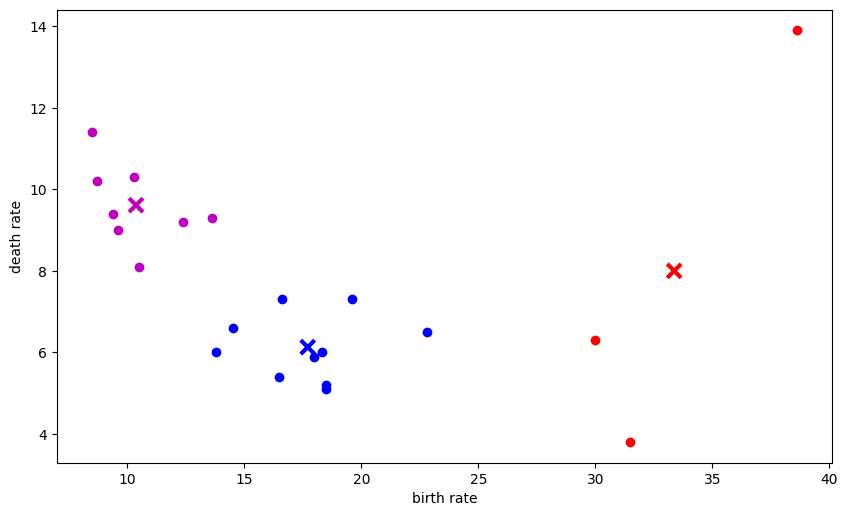

In [50]:
import itertools
fig=plt.figure(figsize=(10,6), dpi= 100)

palette = itertools.cycle(['b','r','m'])
for c in range(3):
  cclusterx = [ x[1] for x in countriesdata if cpredictions[x[0]] == c]               
  cclustery = [ x[2] for x in countriesdata if cpredictions[x[0]] == c]  
  plt.scatter(cclusterx,cclustery,color=next(palette) )
     
centersX = [ x[0] for x in countriesclusters1.centers ]
centersY = [ x[1] for x in countriesclusters1.centers ]
# Plot the center of each cluster
plt.scatter(centersX, centersY, marker='x', s=100, linewidths=3, color=['b','r','m'], zorder=10) 

plt.xlabel('birth rate')
plt.ylabel('death rate')
plt.show()    

### Example domain: clustering similar users

Let's now turn our attention to the topic of discovering similar users for recommender systems. In particular, let's consider a data base of users, where for each user we store the ratings given by the user to different movies. We will talk more about recommender systems later in this course, dicussing more appropriate ways of dealing with such data, where tipically many entries (actually most of the entries) of such user-product matrix will be empty, so this clustering approach may not be always usable.

In [8]:
# Example data
#
# We have 10 users, and 10 movies: STW1, STW2, STW3, STW4, STW5, STW6
#                                  T1, T2, T3 and BaT
# Each entry i,j is the rating given by the user in the range [-5.0,5.0]
# We can observe that we have 4 clear Star Wars fans (that they also like a 
# little bit Terminator movies)
# We also have four clear Terminator fans (that they also like a little STWs movies)
# Finally, we have two clear Breakfast at tiffannies fans (BaT), that they do not
# like too much science-fiction movies

usersandmovies = [ [3,3,3,5,5,4, 3,3,-1, -1], \
                   [3,3,3,5,5,4, 4,2,0, -1], \
                   [3,3,4,5,5,4, 4,4,1, 0], \
                   [4,3,3,4,5,4, 3,3,1, -1], \
                   [1,1,1,0,1,1, 5,4,2, -1], \
                   [1,2,1,0,1,1, 4,4,2, -1], \
                   [1,2,2,1,1,1, 4,4,2, -1], \
                   [1,2,2,1,1,0, 5,4,3, -1], \
                   [-2,-3,-2,0,-2,-1, 0,0,-1,4], \
                   [-2,-3,-2,0,-2,-1, 0,0,-1,4]   ]

The code we use for discovering three clusters in this second data set is almost identical to the previous one, given that the input data format is almost the same:

In [21]:
usersandmoviesRDD = sc.parallelize( usersandmovies ).map( lambda p : np.array(p) )
usersandmoviesRDD.persist()

# Cluster the data in 3 clusters
userclusters1 = KMeans.train( usersandmoviesRDD, 3, maxIterations=5, \
                               initializationMode="random")

In [22]:
for user in usersandmovies:
    print ("Cluster for ", user, " : ", userclusters1.predict(np.array(user)))

WCSSE = usersandmoviesRDD.map(lambda point: error(userclusters1,point)).reduce(lambda x, y: x + y)
print("Within Cluster Sum of Squared Error = " + str(WCSSE))

Cluster for  [3, 3, 3, 5, 5, 4, 3, 3, -1, -1]  :  0
Cluster for  [3, 3, 3, 5, 5, 4, 4, 2, 0, -1]  :  0
Cluster for  [3, 3, 4, 5, 5, 4, 4, 4, 1, 0]  :  0
Cluster for  [4, 3, 3, 4, 5, 4, 3, 3, 1, -1]  :  0
Cluster for  [1, 1, 1, 0, 1, 1, 5, 4, 2, -1]  :  2
Cluster for  [1, 2, 1, 0, 1, 1, 4, 4, 2, -1]  :  2
Cluster for  [1, 2, 2, 1, 1, 1, 4, 4, 2, -1]  :  2
Cluster for  [1, 2, 2, 1, 1, 0, 5, 4, 3, -1]  :  2
Cluster for  [-2, -3, -2, 0, -2, -1, 0, 0, -1, 4]  :  1
Cluster for  [-2, -3, -2, 0, -2, -1, 0, 0, -1, 4]  :  1
Within Cluster Sum of Squared Error = 14.0


Observe that in *almost all* the executions of k-means with this data set, we discover the three subgroups of user profiles we have intentionally introduced in this data set of user movie reviews. However, in some executions the clusters discovered differ slightly, and the WCSSE increases from 14 to 35.

##  The bisecting k-means algorithm 


This algorithm is a variant of the k-means algorithm, that works by creating a tree of clusters, being the final set of k leaf clusters the clusters finally provided. The original version is from the paper "A comparison of document clustering techniques", by Steinbach, Karypis, and Kumar:

 https://www.researchgate.net/publication/2628533_A_Comparison_of_Document_Clustering_Techniques



We present here the version implemented in Spark, in pseudo-code:


```python
level=0
# Start with a single cluster, but we want to have k
Clusters[level] = [[All the points]] 
while ( len(Clusters[level] < k and
         there are divisible clusters):
   tobisect = pickDivisibleClusters(Clusters[level])
   # Make two child clusters from each cluster in tobisect:       
   Clusters[level+1] =
       [RunKmeans(cluster,2,maxIterations) for cluster in tobisect]
   level=level+1    
```

- The bisecting steps of clusters on the same level are executed in parallel.
- If bisecting all divisible clusters on the curent level would result in more than `k` leaf clusters, larger clusters will be the ones picked
- A cluster is divisible if its number of points is above certain **minimum number of points**
> It may be necessary to set this minimum value not too small, to avoid overfiting problems

Next, let's see this Bisecting k-means algorithm executed in spark

In [14]:
from pyspark.mllib.clustering import BisectingKMeans


In [15]:
# Cluster the data in 3 clusters, but starting from one big cluster
# and bisecting clusters until we finally get k (3) clusters
userclusters2 = BisectingKMeans.train( usersandmoviesRDD, 3, maxIterations=5)

In [23]:
for user in usersandmovies:
    print ("Cluster for ", user, " : ", userclusters2.predict(np.array(user)))

WCSSE = userclusters2.computeCost(usersandmoviesRDD)
print("Within Cluster Sum of Squared Error = " + str(WCSSE))

Cluster for  [3, 3, 3, 5, 5, 4, 3, 3, -1, -1]  :  2
Cluster for  [3, 3, 3, 5, 5, 4, 4, 2, 0, -1]  :  2
Cluster for  [3, 3, 4, 5, 5, 4, 4, 4, 1, 0]  :  2
Cluster for  [4, 3, 3, 4, 5, 4, 3, 3, 1, -1]  :  2
Cluster for  [1, 1, 1, 0, 1, 1, 5, 4, 2, -1]  :  1
Cluster for  [1, 2, 1, 0, 1, 1, 4, 4, 2, -1]  :  1
Cluster for  [1, 2, 2, 1, 1, 1, 4, 4, 2, -1]  :  1
Cluster for  [1, 2, 2, 1, 1, 0, 5, 4, 3, -1]  :  1
Cluster for  [-2, -3, -2, 0, -2, -1, 0, 0, -1, 4]  :  0
Cluster for  [-2, -3, -2, 0, -2, -1, 0, 0, -1, 4]  :  0
Within Cluster Sum of Squared Error = 14.0
